<a href="https://colab.research.google.com/github/nv-hiep/dust_grain_fit/blob/main/run_dustfit_MRN77_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dust Grain Fit using MRN1977 model (MW) - pymc3**

# 1. Mount the google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# !ls

Mounted at /content/gdrive


In [2]:
!pip3 install uncertainties

     |████████████████████████████████| 256kB 7.1MB/s 


In [ ]:
# !pip3 install pymc3>=3.8

In [ ]:
# !pip3 install arviz

# 2. Root directory

In [5]:
cd '/content/gdrive/My Drive/Colab Notebooks/dustfit'

/content/gdrive/My Drive/Colab Notebooks/dustfit


# 3. Import Libraries



In [6]:
#!/usr/bin/env python
from __future__ import print_function

import os
import sys
import time
import pickle

import numpy             as np
import matplotlib.pyplot as pyplot

import matplotlib
from matplotlib.ticker import ScalarFormatter

import pymc3   as pm

import theano
import theano.tensor as tt

import pandas as pd
# from pymc3.backends.base import MultiTrace=

import uncertainties.unumpy as unp

from astropy.io     import fits

from libs.dustmodel import DustModel, MRN77, WD01
from libs.dustdata  import DustData

%matplotlib inline

## 4. Data

In [7]:
# Path to the data
root_path = os.getcwd()
print(os.getcwd())
print(os.path.dirname(os.path.realpath('__file__')))

/content/gdrive/My Drive/Colab Notebooks/dustfit
/content/gdrive/My Drive/Colab Notebooks/dustfit


In [8]:
# Pymc3 params for the fit
sel_step     = None
sizedisttype = 'MRN'
gal          = 'MW'

# set the prefix_filename of the output
prefile = os.path.join(root_path, 'results', sizedisttype) # eg: path.. results/test_MRN

print('The prefix_filename of the output file: ', prefile)


# Path to data
path = os.path.join(root_path, 'data', gal)

The prefix_filename of the output file:  /content/gdrive/My Drive/Colab Notebooks/dustfit/results/MRN


In [9]:
# Read observed data 
obsdata = DustData(path,
                    abundance  = True,
                    extinction = True,
                    emission   = True,
                    scattering = True,
                    ISRF       = True )

In [10]:
def get_arr_obsdata(obsdata):
    
    # extinction
    yobs      = obsdata.ext_AlNHI
    yerr      = obsdata.ext_AlNHI_err

    # Abundances
    atomabund_y    = []
    atomabund_yerr = []
    for atomname, atomval in obsdata.abundance.items():
        atomabund_y.append( obsdata.abundance[atomname][0] )
        atomabund_yerr.append( obsdata.abundance[atomname][1] )

    atomabund_y    = np.array(atomabund_y)
    atomabund_yerr = np.array(atomabund_yerr)

    yobs           = np.concatenate( [yobs, atomabund_y] )
    yerr           = np.concatenate( [yerr, atomabund_yerr] )

    # Emission
    yobs           = np.concatenate( [yobs, obsdata.spec_] )
    yerr           = np.concatenate( [yerr, obsdata.spec_err] )

    # Albedo
    yobs           = np.concatenate( [yobs, obsdata.scat_albedo] )
    yerr           = np.concatenate( [yerr, obsdata.scat_albedo_err] )

    # g=cos(theta)
    yobs           = np.concatenate( [yobs, obsdata.scat_g] )
    yerr           = np.concatenate( [yerr, obsdata.scat_g_err] )

    return (yobs, yerr)

In [11]:
# Grain components
grain_types = ['silicates','carbonaceous']


# # min and max grain radii for MRN distribution
# AMIN     = 0.005   # micron
# AMAX     = 0.3     # micron
if sizedisttype == 'MRN':
    
    # define the fitting model
    dustmodel = MRN77(componentnames=grain_types, path=root_path, from_obs=True, sel_step=sel_step)

    p0 = []
    pnames = []
    for k, component in enumerate(dustmodel.components):
        cparams = dustmodel.parameters[component.name]
        p0     += [cparams['C'], cparams['p'], cparams['amin'], cparams['amax']]
        pnames += [ 'C'+str(k), 'p'+str(k), 'amin'+str(k), 'amax'+str(k) ]

    # need to set dust model size distribution
    # sizedist = A*a^-alpha, A = params['C'] : Amplitude
    dustmodel.set_size_dist(p0)




elif sizedisttype == 'WD':

    dustmodel = WD01(componentnames=grain_types, path=root_path, from_obs=True, sel_step=sel_step)

    # initial guesses at parameters
    p0     = []
    pnames = []
    for k, component in enumerate(dustmodel.components):
        if component.name == 'silicates':
            cparams  = dustmodel.parameters['silicates']
            p0      += [ cparams['C_s'], cparams['a_ts'], cparams['alpha_s'], cparams['beta_s'] ]
            pnames  += ['C_s'+str(k), 'a_ts'+str(k), 'alpha_s'+str(k), 'beta_s'+str(k)]
        else:
            cparams  = dustmodel.parameters['carbonaceous']
            p0      += [cparams['C_g'], cparams['a_tg'], cparams['alpha_g'], cparams['beta_g'], cparams['a_cg'],cparams['b_C'] ]
            pnames  += [ 'C_g'+str(k), 'a_tg'+str(k), 'alpha_g'+str(k), 'beta_g'+str(k), 'a_cg'+str(k), 'b_C'+str(k)]

    # need to set dust model size distribution
    dustmodel.set_size_dist(p0)

else:
    print('Please select a size distribution [MRN, WD]')
    exit()
# End - if

In [12]:
# Initial values of paramters, and number of parameters
print('p0: ', p0)
print('param names: ', pnames)
npars = len(p0)
print('Number of params: ', npars)



for k, component in enumerate(dustmodel.components):
    print('Component: ', component)
    print( 'Size distribution:', component.size_dist )
    print( 'Length of size distribution:', len(component.size_dist) )
    print()


# Get the observed data as arrays of yobs and yerr
(yobs, yerr) = get_arr_obsdata(obsdata)

p0:  [1e-25, 3.5, 1e-07, 0.001, 1e-25, 3.5, 1e-07, 0.001]
param names:  ['C0', 'p0', 'amin0', 'amax0', 'C1', 'p1', 'amin1', 'amax1']
Number of params:  8
Component:  <libs.dustgrains.DustGrains object at 0x7fa7a9ec0278>
Size distribution: [0.00000000e+00 0.00000000e+00 3.05266788e-01 4.89697400e-02
 7.85541979e-03 1.26011037e-03 2.02138776e-04 3.24262632e-05
 5.20156793e-06 8.34401946e-07 1.33849246e-07 2.14711210e-08
 3.44432327e-09 5.52512115e-10 8.86304529e-11 1.42175728e-11
 2.28069506e-12 3.65853453e-13 5.86882697e-14 9.41438191e-15
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Length of size distribution: 25

Component:  <libs.dustgrains.DustGrains object at 0x7fa7ca45e0b8>
Size distribution: [0.00000000e+00 0.00000000e+00 3.05266788e-01 4.89697400e-02
 7.85541979e-03 1.26011037e-03 2.02138776e-04 3.24262632e-05
 5.20156793e-06 8.34401946e-07 1.33849246e-07 2.14711210e-08
 3.44432327e-09 5.52512115e-10 8.86304529e-11 1.42175728e-11
 2.28069506e-12 

In [13]:
@theano.compile.ops.as_op(itypes=[tt.dscalar]*npars, otypes=[tt.dvector])
def model_fcn(*args):
    '''
    | Dust model function
    |
    | --Params:
    |           args: List of input parameters (params of MRN77/WD01 models)
    |
    | --Return:
    |          Array of dust properties calculated from the model
    '''

    # p_pars = [float(C0), float(p0), float(amin0), float(amax0), float(C1), float(p1), float(amin1), float(amax1)]
    p_pars = [float(x) for x in args]

    # Update size_dist, self.component.size_dist (25,)
    dustmodel.set_size_dist(p_pars)


    # Values from model
    model_values = dustmodel.eff_grain_props(obsdata)

    model_fit = []

    # extinction
    model_fit = 1.086 * (model_values['cabs'] + model_values['csca'])

    # Abundances
    natoms         = model_values['natoms']
    atomabund_mod  = []
    for atomname, atomval in natoms.items():
        atomabund_mod.append( atomval )

    model_fit = np.concatenate( [model_fit, np.array(atomabund_mod)] )

    # emission
    model_fit = np.concatenate( [model_fit, model_values['emission']] )

    # albedo
    model_fit = np.concatenate( [model_fit, model_values['albedo']] )

    # g=cos(theta)
    model_fit = np.concatenate( [model_fit, model_values['g']] )

    return model_fit

In [15]:
# Setup the pm3 model
with pm.Model() as model:

    # Priors
    prior_pars = {}
    for name, val  in zip( pnames, p0 ):
        # prior_pars[name] = pm.Uniform(name, lower=ps, upper=pf) # uniform prior
        prior_pars[name] = pm.Normal(name, mu=val, sd=0.05*val)


    # Expected value of outcome, a.k.a  the model
    mu = model_fcn(*[ prior_pars[name] for name in pnames])

    # Likelihood (sampling distribution) of observations
    _ = pm.Normal('Y_obs', mu=mu, sd=yerr, observed=yobs)
# end - with



'''
 Setup the pm3 params for the fit
 n_sample : number of samples to take
 chains   : number of concurrent chains
 burn     : number of initial samples to burn
 thin     : multiple of samples to keep
'''
n_sample = 1000
tune     = 1000

chains   = 3
burn     = int(0.1*n_sample)
thin     = 5


#>>>> Run the fit
with model:
    #start = pm.find_MAP()
    #step =pm.NUTS()
    start = {}
    for k,v in zip(pnames, p0) :
        start[k] = v
    step = pm.Metropolis()

with model:
    trace = pm.sample(n_sample, step, start, chains=chains, tune=tune)
#<<<<    

Sequential sampling (3 chains in 1 job)
CompoundStep
>Metropolis: [amax1]
>Metropolis: [amin1]
>Metropolis: [p1]
>Metropolis: [C1]
>Metropolis: [amax0]
>Metropolis: [amin0]
>Metropolis: [p0]
>Metropolis: [C0]
100%|██████████| 2000/2000 [14:44<00:00,  2.26it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
tracefile = os.path.join(root_path, 'results', 'trace_MRN77.pkl')
with open(tracefile, 'wb') as f:
  pickle.dump(trace, f)

In [21]:
# pm.traceplot(trace)
# plt.show()

In [20]:
# import arviz as az
# v_waic = az.waic(trace)
# print('\nWAIC statistics...\n', v_waic)

In [22]:

# Save the best fit params
fit_params_best = []
dat             = {}
for par in pnames:
    values = trace.get_values(par, burn=burn, thin=thin)
    fit_params_best.append(values.mean(axis=0))

    dat[par+'_mean'] = [values.mean(axis=0)]
    dat[par+'_std']  = [values.std(axis=0)]


# Mean and std of the params
print('Mean and std of the params: ')
print(dat)

# Save the params to csv
df = pd.DataFrame(data=dat)
df.to_csv(index=False)
df.head()

Mean and std of the params: 
{'C0_mean': [1.0000000000000002e-25], 'C0_std': [1.1479437019748901e-41], 'p0_mean': [3.4536571989254257], 'p0_std': [0.03079713828749795], 'amin0_mean': [3.841750151942456e-08], 'amin0_std': [8.335433260896061e-09], 'amax0_mean': [0.0006864574083813371], 'amax0_std': [0.00045180851390186626], 'C1_mean': [1.0000000000000002e-25], 'C1_std': [1.1479437019748901e-41], 'p1_mean': [2.9616375007237847], 'p1_std': [0.4003346388496857], 'amin1_mean': [7.799319536390118e-08], 'amin1_std': [3.0513225401574005e-08], 'amax1_mean': [0.0006402575480181969], 'amax1_std': [0.0004294636926467557]}


,C0_mean,C0_std,p0_mean,p0_std,amin0_mean,amin0_std,amax0_mean,amax0_std,C1_mean,C1_std,p1_mean,p1_std,amin1_mean,amin1_std,amax1_mean,amax1_std
0,1.000000e-25,1.147944e-41,3.453657,0.030797,3.841750e-08,8.335433e-09,0.000686,0.000452,1.000000e-25,1.147944e-41,2.961638,0.400335,7.799320e-08,3.051323e-08,0.00064,0.000429


In [23]:
# Save to pickle f
filename = prefile +'_pymc3_' + str(n_sample) + '_' + str(burn) + '.pickle'
dustmodel.save_best_results(filename, fit_params_best, obsdata)

for xname,xval in zip(pnames, fit_params_best):
  print('%s : %s'%(xname, xval) )

C0 : 1.0000000000000002e-25
p0 : 3.4536571989254257
amin0 : 3.841750151942456e-08
amax0 : 0.0006864574083813371
C1 : 1.0000000000000002e-25
p1 : 2.9616375007237847
amin1 : 7.799319536390118e-08
amax1 : 0.0006402575480181969


In [37]:
def get_krange(x, logaxis=False, in_range=[0]):

    prange = np.array([0.0, 0.0])
    if logaxis:
        gindxs = x > 0
        min_x = np.amin(x[gindxs])
        max_x = np.amax(x[gindxs])
    else:
        min_x = np.amin(x)
        max_x = np.amax(x)

    if logaxis:
        max_x = np.log10(max_x)
        if min_x <= 0.0:
            min_x = max_x - 10.0
        else:
            min_x = np.log10(min_x)

    delta = max_x - min_x
    prange[0] = min_x - 0.1 * delta
    prange[1] = max_x + 0.1 * delta

    if logaxis:
        prange = np.power(10.0, prange)

    if len(in_range) > 1:
        prange[0] = np.minimum(prange[0], in_range[0])
        prange[1] = np.maximum(prange[1], in_range[1])

    return prange


# plot the size distributions
def plot_sizedist(ax, data, colors=['b', 'g'], fontsize=12, multa4=True, plegend=True, ltype='-', alpha=1.):

    yrange = [0]
    for i in range(data['n_components']):

        xvals = data['sizes'][i] * 1.e4
        yvals = data['size_dist'][i]

        if multa4:
            xvals4 = data['sizes'][i] ** 4
            yvals = yvals * xvals4

        yrange = get_krange(yvals, logaxis=True, in_range=yrange)

        gindxs = yvals > 0

        ax.plot(xvals[gindxs], yvals[gindxs], colors[i] + ltype, label=data['component_names'][i], alpha=alpha)

    if multa4:
        ylabel = r'$a^4 N_d(a)/N(H)$'
        ylim   = (1.e-33, 1.e-26)
    else:
        ylabel = r'$N_d(a)/N(H)$'
        ylim   = (1.e-18, 10.)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(get_krange(xvals, logaxis=True))
    ax.set_ylim(ylim)
    ax.set_xlabel(r'$a [\mu m]$', fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.legend()


# plot the atomic abundances
def plot_abundances(ax, data, obsdata, colors=['r', 'b', 'g'], fontsize=12):

    # plot the dust abundances
    atomnames = []
    atomabund = []
    for k,v in data['abundance'].items():
        atomnames.append(k)
        atomabund.append(v)

    n_atoms   = len(atomnames)
    aindxs    = np.arange(n_atoms)
    width     = 0.5
    ax.bar(aindxs + 0.75 * width, atomabund, width)

    ax.errorbar(aindxs + 0.75 * width, [obsdata.abundance[x][0] for x in atomnames],
                yerr=[obsdata.abundance[x][1] for x in atomnames],
                fmt='ko', label='Observed')

    ax.set_ylabel(r'$N(X)/[10^6 N(H)]$', fontsize=fontsize)
    ax.set_xticks(aindxs + (0.75 * width))
    ax.set_xticklabels(atomnames)


# plot the extinction curves (total and components)
def plot_extinction(ax, data, obsdata, colors=['r', 'b', 'g'], fontsize=12, comps=True, ltype='-'):

    ax.plot(1./data['wavelengths'], data['ext'], colors[0] + ltype, lw=5, label='Total')
    yrange = get_krange(data['ext'], logaxis=True)
    
    if comps:
        for i in range(data['n_components']):
            ax.plot(1./data['wavelengths'], data['ext_components'][i], colors[i + 1] + ltype)
            yrange = get_krange(data['ext_components'][i], logaxis=True, in_range=yrange)

    ax.plot(1./obsdata.ext_lambda, obsdata.ext_AlNHI, 'k-', label='Observed')
    yrange = get_krange(obsdata.ext_AlNHI, logaxis=True, in_range=yrange)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\lambda [\mu m]$', fontsize=fontsize)
    ax.set_ylabel(r'$A(\lambda)/N(H)$', fontsize=fontsize)

    ax.set_xlim(get_krange(1./data['wavelengths'], logaxis=True))
    ax.set_ylim(yrange)
    ax.legend()


# plot the emission spectra (total and components)
def plot_emission(ax, data, obsdata, colors=['r', 'b', 'g'], fontsize=12, comps=True, ltype='-'):
    ax.plot(data['emission_wavelengths'], data['emission'], colors[0] + ltype, lw=5)
    yrange = get_krange(data['emission'], logaxis=True)
    
    if comps:
        for i in range(data['n_components']):
            ax.plot(data['emission_wavelengths'], data['emission_components'][i], colors[i + 1] + ltype)
            yrange = get_krange(data['emission_components'][i], logaxis=True, in_range=yrange)

    ax.errorbar( obsdata.emis_lambda, obsdata.spec_, yerr=obsdata.spec_err, fmt='ko', label='Observed')
    yrange = get_krange(obsdata.spec_, logaxis=True, in_range=yrange)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\lambda [\mu m]$', fontsize=fontsize)
    ax.set_ylabel(r'$S$ $[MJy$ $sr^{-1}$ $N(H)^{-1}]$', fontsize=fontsize)

    ax.set_xlim(get_krange(data['emission_wavelengths'], logaxis=True))
    ax.set_ylim(yrange)
    ax.legend()


# plot the dust scattering albedo
def plot_albedo(ax, data, obsdata, colors=['r', 'b', 'g'], fontsize=12, comps=True, ltype='-'):

    ax.plot(data['albedo_wavelengths'], data['albedo'], colors[0] + ltype, lw=5)
    yrange = get_krange(data['albedo'])
    if comps:
        for i in range(data['n_components']):
            ax.plot( data['albedo_wavelengths'], data['albedo_components'][i], colors[i + 1] + ltype)
            yrange = get_krange(data['albedo_components'][i], in_range=yrange)

    ax.errorbar(obsdata.scat_albedo_lambda, obsdata.scat_albedo, yerr=obsdata.scat_albedo_err, fmt='ko', label='Observed')
    # yrange = get_krange(obsdata.scat_albedo, in_range=yrange)

    ax.set_xscale('log')
    ax.set_xlabel(r'$\lambda [\mu m]$', fontsize=fontsize)
    ax.set_ylabel(r'$albedo$', fontsize=fontsize)

    ax.set_xlim(get_krange(data['albedo_wavelengths'], logaxis=True))
    ax.set_ylim([0., 1.])
    # ax.set_ylim(yrange)

/content/gdrive/My Drive/Colab Notebooks/dustfit/results/MRN_pymc3_1000_100.pickle


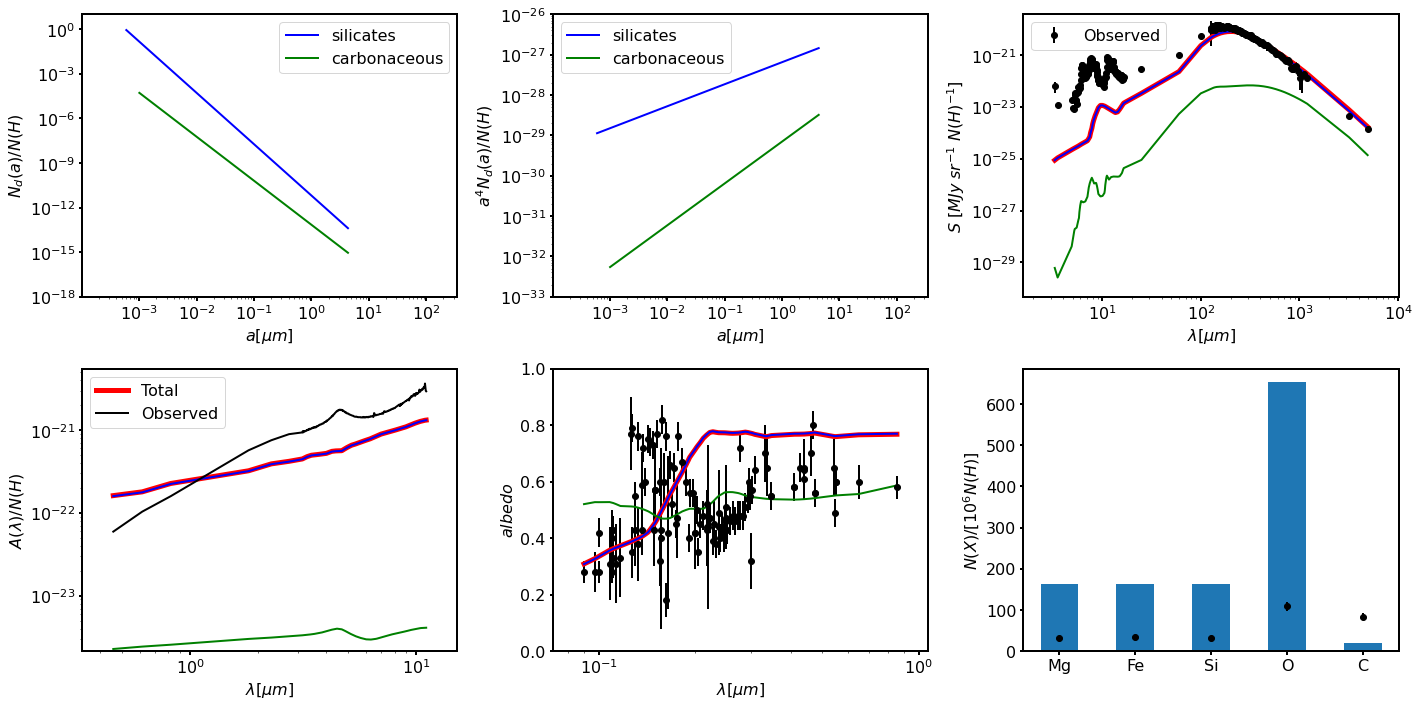

In [38]:
print(filename) # prefile +'_pymc3_' + str(n_sample) + '_' + str(burn) + '.pickle'

# Read the results
with open(filename, 'rb') as xfile:
    result = pickle.load(xfile)


# setup the plots
fontsize = 16
font = {"size": fontsize}

matplotlib.rc("font", **font)

matplotlib.rc("lines", linewidth=2)
matplotlib.rc("axes", linewidth=2)
matplotlib.rc("xtick.major", width=2)
matplotlib.rc("ytick.major", width=2)

# Figure
fig, ax = pyplot.subplots(ncols=3, nrows=2, figsize=(20, 10))

# plot the dust size distributions
colors = ['b', 'g']
plot_sizedist(ax[0, 0], result, fontsize=fontsize, multa4=False)
plot_sizedist(ax[0, 1], result, fontsize=fontsize, plegend=False)

# plot the resulting total and component emission spectra
plot_emission(ax[0, 2], result, obsdata, fontsize=fontsize)

# plot the resulting total and component extinction curves
plot_extinction(ax[1, 0], result, obsdata, fontsize=fontsize)

# plot the resulting total and component emission spectra
plot_albedo(ax[1, 1], result, obsdata, fontsize=fontsize)

# plot the abundances
plot_abundances(ax[1, 2], result, obsdata, fontsize=fontsize)

pyplot.tight_layout()

# show
pyplot.show()